# Demonstration of HAVOK Method

In [1]:
import os
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
from scipy.integrate import odeint


rcParams.update({'font.size': 14})
#plt.rcParams['figure.figsize'] = [12, 12]

In [2]:
# Directory for plot outputs
plot_dir = '../../plots'

## Simulate the Lorenz System

In [3]:
dt = 0.01
T = 50
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10
rho = 28

def lorenz_odes(t, y, sigma, beta, rho):
    """The Lorenz system of ordinary differential equations.
    
    Returns:
        dydt (tuple): Derivative w.r.t. time
    """
    y1, y2, y3 = y
    return (sigma * (y2 - y1), y1 * (rho - y3) - y2, y1 * y2 - beta * y3)

# Test calculation
assert lorenz_odes(0, [1, 2, 3], sigma, beta, rho) == (10, 23, -6.0)

In [4]:
# Simulate using scipy.integrate.odeint method
# Produces same results as Matlab

# Initial condition
x0 = (-8, 8, 27)
fun = partial(lorenz_odes, sigma=sigma, beta=beta, rho=rho)
rtol = 10e-12
atol = 10e-12 * np.ones_like(x0)
x = odeint(fun, x0, t, tfirst=True, rtol=rtol, atol=atol)
assert x.shape == (5001, 3)

x[:5, :].round(3)

array([[-8.   ,  8.   , 27.   ],
       [-6.486,  7.803, 25.726],
       [-5.138,  7.563, 24.609],
       [-3.942,  7.313, 23.629],
       [-2.882,  7.078, 22.766]])

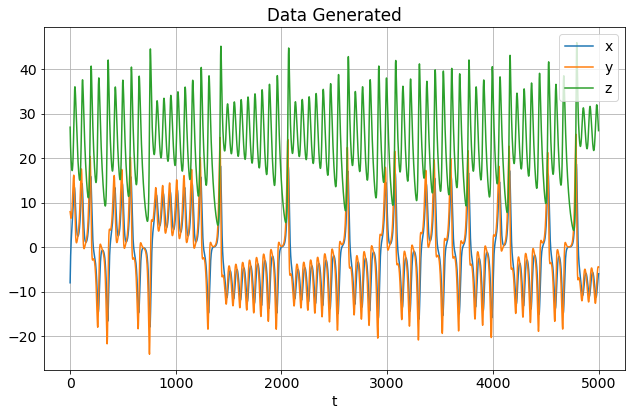

In [5]:
plt.figure(figsize=(9, 6))
plt.plot(x)
plt.title('Data Generated')
plt.xlabel('t')
plt.legend(labels=['x', 'y', 'z'])
plt.grid()
plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_data.png')
plt.savefig(filepath)
plt.show()

In [6]:
def scatter_plot_3d(data, labels=('x', 'y', 'z'), 
                    show=True, cmap='RdYlBu', 
                    figsize=(9, 7), filename=None):
    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]
    cm = plt.cm.get_cmap(cmap)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    t = range(len(data))
    cbar = ax.scatter(x, y, z, c=t, marker='.', cmap=cm)
    cbar = plt.colorbar(cbar)
    cbar.set_label('Time (t)')

    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    
    if filename is not None:
        plt.tight_layout()
        plt.savefig(filename)

    if show:
        plt.show()


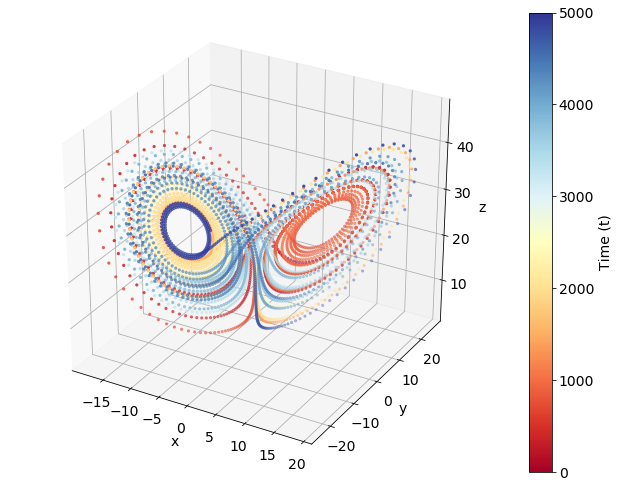

In [7]:
filepath = os.path.join(plot_dir, 'lorenz_data_3d.png')
scatter_plot_3d(x, filename=filepath)

## Take data for one measurement $x(t)$

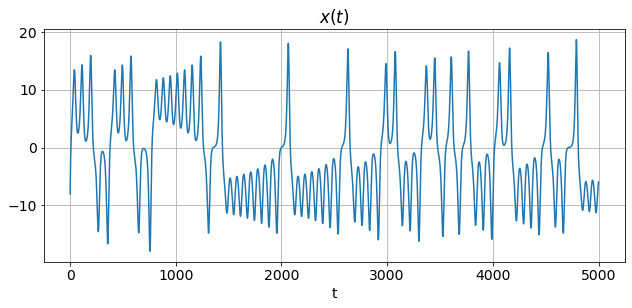

In [8]:
plt.figure(figsize=(9, 4.5))
plt.plot(x[:, 0])
plt.title('$x(t)$')
plt.xlabel('t')
plt.grid()
plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_data_x.png')
plt.savefig(filepath)
plt.show()

In [9]:
def hankel_matrix(x, n_shift):
    """Hankel matrix of eigen-time-delay coordinates.
    """
    assert n_shift > 1
    h = np.stack([np.roll(x, -i) for i in range(n_shift)])
    return h[:, :-n_shift+1]

h_test = hankel_matrix(np.array(range(5)), 3)
h_true = np.array([
    [0, 1, 2],
    [1, 2, 3],
    [2, 3, 4]
])
assert np.array_equal(h_test, h_true)

## Eigen-time delay coordinates

In [10]:
# Number of shifted rows
n_shift = 10
H = hankel_matrix(x[:, 0], n_shift)
H.shape

(10, 4992)

In [11]:
H[:, :5].round(3)

array([[-8.   , -6.486, -5.138, -3.942, -2.882],
       [-6.486, -5.138, -3.942, -2.882, -1.944],
       [-5.138, -3.942, -2.882, -1.944, -1.113],
       [-3.942, -2.882, -1.944, -1.113, -0.375],
       [-2.882, -1.944, -1.113, -0.375,  0.284],
       [-1.944, -1.113, -0.375,  0.284,  0.877],
       [-1.113, -0.375,  0.284,  0.877,  1.414],
       [-0.375,  0.284,  0.877,  1.414,  1.905],
       [ 0.284,  0.877,  1.414,  1.905,  2.36 ],
       [ 0.877,  1.414,  1.905,  2.36 ,  2.787]])

In [12]:
# Compute SVD
U, S, VT = np.linalg.svd(H, full_matrices=False)
V = VT.T

U.shape, S.shape, V.shape

((10, 10), (10,), (4992, 10))

In [13]:
## Compute Derivatives (4th Order Central Difference)
dV = (1/(12*dt)) * (-V[4:,:] + 8*V[3:-1,:] - 8*V[1:-3,:] + V[:-4,:])

# trim first and last two that are lost in derivative
V = V[2:-2]
V.shape

(4988, 10)

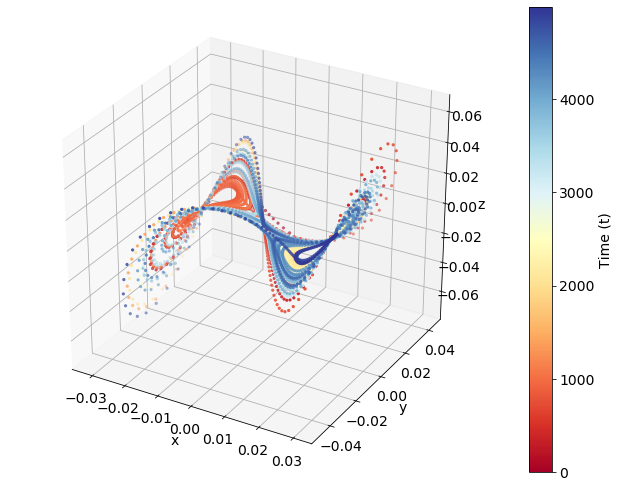

In [14]:
# First 3 columns of V are an embedded attractor of the Lorenz system
filepath = os.path.join(plot_dir, 'lorenz_embedded.png')
scatter_plot_3d(V[:,:3], filename=filepath)

## Build HAVOK Regression Model on Time Delay Coordinates

In [15]:
xi = np.linalg.lstsq(V, dV, rcond=None)[0]
xi.shape

(10, 10)

In [16]:
# Choose rank of HAVOK model
r = 10

A = xi[:(r-1), :(r-1)].T
B = xi[-1, :(r-1)].T

A.shape, B.shape

((9, 9), (9,))

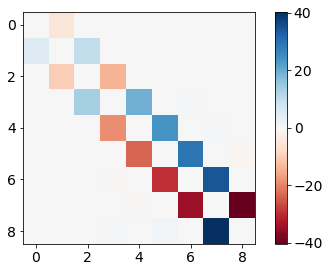

In [17]:
plt.imshow(A, cmap='RdBu')
plt.colorbar()
plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_reg_model.pdf')
plt.savefig(filepath)
plt.show()

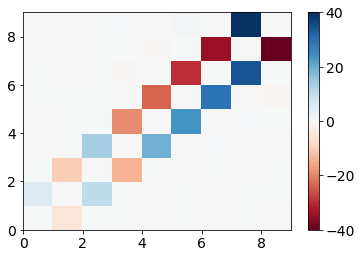

In [24]:
c = plt.pcolormesh(A, cmap='RdBu', vmin=-40, vmax=40)
plt.colorbar()

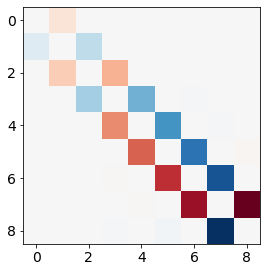

In [38]:
plt.imshow(A, cmap='RdBu')
#plt.colorbar()
plt.clim(-40, 40)
plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_reg_model.png')
plt.savefig(filepath)
plt.show()

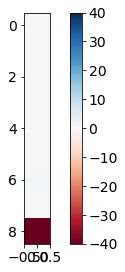

In [37]:
plt.imshow(B.reshape(-1,1), cmap='RdBu')
plt.colorbar()
plt.clim(-40, 40)
plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_reg_model_b.png')
plt.savefig(filepath)
plt.show()

## Make Predictions with the Model